# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import yaml
from utils import *
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import scipy.misc as scm
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
np.random.seed(0)

/pghbio/dbmi/batmanlab/singla/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:12: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/pghbio/dbmi/batmanlab/singla/anaconda/lib/python2.7/site-packages/sklearn/utils/extmath.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/pghbio/dbmi/batmanlab/singla/anaconda/lib/python2.7/site-packages/sklearn/utils/extmath.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/pghbio/dbmi/batmanlab/singla/anaconda/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_informa

# Read config

In [2]:
config = '../configs/celebA_Young_Classifier.yaml'
config = yaml.load(open(config))
for k in config.keys():
    print(k, config[k])

('num_class', 1)
('name', 'CelebA-Young')
('image_dir', '/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images')
('ckpt_dir_continue', '')
('batch_size', 32)
('num_channel', 3)
('epochs', 5)
('train', './data/CelebA/train_ids.npy')
('log_dir', './output/classifier')
('test', './data/CelebA/test_ids.npy')
('input_size', 128)
('image_label_dict', './data/CelebA/Young_binary_classification.txt')


In [3]:
output_dir = os.path.join('.'+config['log_dir'], config['name'], 'classifier_output')
print(output_dir)

../output/classifier/CelebA-Young/classifier_output


In [5]:
categories, file_names_dict = read_data_file('.'+config['image_label_dict'])
print(categories)

['Young']


# Load saved output from classifier

In [9]:
# Read classifier output
train_or_test = 'train'
names = np.load(os.path.join(output_dir, 'name_' +train_or_test+'.npy'))
prediction_y = np.load(os.path.join(output_dir, 'prediction_y_' +train_or_test+'.npy'))
true_y = np.load(os.path.join(output_dir, 'true_y_' +train_or_test+'.npy'))
train_or_test = 'test'
names_i = np.load(os.path.join(output_dir,'name_' +train_or_test+'.npy'))
prediction_y_i = np.load(os.path.join(output_dir, 'prediction_y_' +train_or_test+'.npy'))
true_y_i = np.load(os.path.join(output_dir, 'true_y_' +train_or_test+'.npy'))
print(names.shape, prediction_y.shape, true_y.shape)
print(names_i.shape, prediction_y_i.shape, true_y_i.shape)

((182592,), (182592, 2), (182592,))
((19904,), (19904, 2), (19904,))


In [10]:
true_y = np.reshape(true_y, [-1,len(categories)])
true_y_i = np.reshape(true_y_i, [-1,len(categories)])

## View results from classifier

In [11]:
for i in range(prediction_y.shape[1]):
    print(categories[i],i)
    if prediction_y.shape[1] == 2:
        j = 1
    else:
        j = i
    print("ROC-AUC train: ", roc_auc_score(true_y[:,i], prediction_y[:,j]))
    try:
        print("ROC-AUC test: ", roc_auc_score(true_y_i[:,i], prediction_y_i[:,j]))
    except:
        a = 0
    print("Accuracy train: ", accuracy_score(true_y[:,i], (prediction_y[:,j]>0.5).astype(int)))
    print("Accuracy test: ", accuracy_score(true_y_i[:,i], (prediction_y_i[:,j]>0.5).astype(int)))
    print("Recall train: ", recall_score(true_y[:,i], (prediction_y[:,j]>0.5).astype(int)))
    print("Recall test: ", recall_score(true_y_i[:,i], (prediction_y_i[:,j]>0.5).astype(int)))
    tp = np.sum((prediction_y[true_y[:,i] == 1,j]>0.5).astype(int))
    tp_i = np.sum((prediction_y_i[true_y_i[:,i] == 1,j]>0.5).astype(int))
    print("Stats train: ", np.unique(true_y[:,i], return_counts=True), tp)
    print("Stats test: ", np.unique(true_y_i[:,i], return_counts=True),tp_i)
    print(confusion_matrix(true_y_i[:,i],  (prediction_y_i[:,j]>0.5).astype(int)))
    print(confusion_matrix(true_y[:,i],  (prediction_y[:,j]>0.5).astype(int)))
    if prediction_y.shape[1] == 2:
        break

('Young', 0)
('ROC-AUC train: ', 0.9550208897069143)
('ROC-AUC test: ', 0.9165445500120394)
('Accuracy train: ', 0.9128220294426919)
('Accuracy test: ', 0.8782154340836013)
('Recall train: ', 0.9640072324556447)
('Recall test: ', 0.9487128450106157)
('Stats train: ', (array([0, 1]), array([ 41008, 141584])), 136488)
('Stats test: ', (array([0, 1]), array([ 4832, 15072])), 14299)
[[ 3181  1651]
 [  773 14299]]
[[ 30186  10822]
 [  5096 136488]]


## Choose a traget class to build explanation

In [12]:
current_index = 0
name = categories[current_index]
print(name)
current_index_prob = 1

Young


## Create a dataframe from results

In [13]:
df_test_results = pd.DataFrame(data = [names_i, true_y_i[:,current_index], prediction_y_i[:,current_index_prob]]).T
df_test_results = df_test_results.rename(index=str, columns={0: "filename", 1: "label", 2:"prob"})
df_test_results['bin'] = np.floor(df_test_results["prob"].astype('float') * 10).astype('int')
print(df_test_results.shape)
print(np.unique(df_test_results['bin'] ,return_counts=True))
df_test_results.head(3)

(19904, 4)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 1542,   681,   563,   568,   600,   689,   898,  1334,  2240,
       10789]))


,filename,label,prob,bin
0,/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_...,0,0.515488,5
1,/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_...,1,0.827865,8
2,/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_...,0,0.00112322,0


In [14]:
df_train_results = pd.DataFrame(data = [names, true_y[:,current_index], prediction_y[:,current_index_prob]]).T
df_train_results = df_train_results.rename(index=str, columns={0: "filename", 1: "label", 2:"prob"})
df_train_results['bin'] = np.floor(df_train_results["prob"].astype('float') * 10).astype('int')
print(df_train_results.shape)
print(np.unique(df_train_results['bin'] ,return_counts=True))
df_train_results.head(3)

(182592, 4)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 15139,   5750,   4677,   4659,   5057,   6274,   8070,  11743,
        20583, 100640]))


,filename,label,prob,bin
0,/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_...,1,0.844439,8
1,/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_...,0,0.62697,6
2,/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_...,1,0.922537,9


In [15]:
df = pd.concat([df_train_results, df_test_results])
df = df.drop_duplicates()
print(df.shape)
df.head(1)

(202496, 4)


,filename,label,prob,bin
0,/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_...,1,0.844439,8


## Plot reliability curve

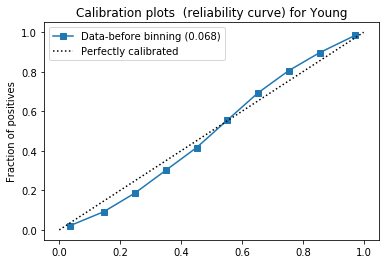

In [16]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df['label']).astype(int)
predicted_prob = np.asarray(df["prob"]).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-before binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
#plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+ name)
plt.legend()
plt.show()

# Create bins

In [17]:
df.head(1)

,filename,label,prob,bin
0,/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_...,1,0.844439,8


In [18]:
df.groupby(by='bin').count()

,filename,label,prob
bin,,,
0,16681,16681,16681
1,6431,6431,6431
2,5240,5240,5240
3,5227,5227,5227
4,5657,5657,5657
5,6963,6963,6963
6,8968,8968,8968
7,13077,13077,13077
8,22823,22823,22823


In [19]:
n = 5000

## Caliberated Sampling

In [20]:
for i in range(10):
    print i
    df_bin = df.loc[df['bin'] == i]
    print(df_bin.shape)
    print(np.min(df_bin['prob']), np.max(df_bin['prob']))
    print(np.unique(df_bin['label'],return_counts=True))
    df_bin_0 = df.loc[(df['bin'] == i) & (df['label'] ==0)]
    df_bin_1 = df.loc[(df['bin'] == i) & (df['label'] ==1)]
    n_0 = int((1 - (0.1 * i) ) * n)
    if df_bin_0.shape[0] >= n_0:
        df_bin = df_bin_0.sample(n=n_0)
    else:
        df_bin = df_bin_0
        n_0 = df_bin_0.shape[0]
    n_1 = n - n_0
    if df_bin_1.shape[0] >= n_1:
        df_bin = pd.concat([df_bin, df_bin_1.sample(n=n_1)])        
    else:
        df_bin = pd.concat([df_bin, df_bin_1])    
        
    if i == 0:
        df_bin_all = df_bin
    else:
        df_bin_all = pd.concat([df_bin, df_bin_all])
    print(df_bin_all.shape)
    print(np.unique(df_bin['label'],return_counts=True))

0
(16681, 4)
(0.0007171524, 0.09998914)
(array([0, 1], dtype=object), array([16318,   363]))
(5000, 4)
(array([0], dtype=object), array([5000]))
1
(6431, 4)
(0.10001118, 0.1999923)
(array([0, 1], dtype=object), array([5839,  592]))
(10000, 4)
(array([0, 1], dtype=object), array([4500,  500]))
2
(5240, 4)
(0.20003144, 0.29999465)
(array([0, 1], dtype=object), array([4261,  979]))
(14979, 4)
(array([0, 1], dtype=object), array([4000,  979]))
3
(5227, 4)
(0.30000046, 0.39999443)
(array([0, 1], dtype=object), array([3650, 1577]))
(19979, 4)
(array([0, 1], dtype=object), array([3500, 1500]))
4
(5657, 4)
(0.40000233, 0.49996912)
(array([0, 1], dtype=object), array([3299, 2358]))
(24979, 4)
(array([0, 1], dtype=object), array([3000, 2000]))
5
(6963, 4)
(0.50001943, 0.5999812)
(array([0, 1], dtype=object), array([3098, 3865]))
(29979, 4)
(array([0, 1], dtype=object), array([2500, 2500]))
6
(8968, 4)
(0.6000243, 0.6999913)
(array([0, 1], dtype=object), array([2754, 6214]))
(34979, 4)
(array([0,

In [21]:
print(np.unique(df_bin_all['bin'] ,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5000, 5000, 4979, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


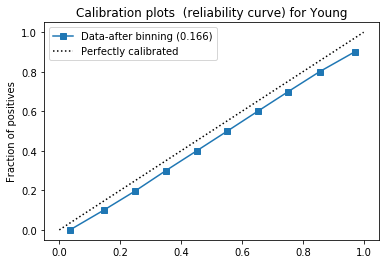

In [22]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_bin_all['label']).astype(int)
predicted_prob = np.asarray(df_bin_all['prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-after binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+name)
plt.legend()
plt.show()

## Save the output

In [23]:
experiment_dir = os.path.join('.'+config['log_dir'], config['name'], 'explainer_input')

In [24]:
print(experiment_dir,name)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

('../output/classifier/CelebA-Young/explainer_input', 'Young')


In [25]:
df_temp = df_bin_all[['filename', 'bin']]
df_temp.to_csv(os.path.join(experiment_dir, 'list_attr_celeba_'+name+'.txt'), sep = ' ', index = None, header = None)
print(df_temp.shape)
one_line = str(df_temp.shape[0]) + '\n'
second_line = "0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99\n"
with open(os.path.join(experiment_dir, 'list_attr_celeba_'+name+'.txt'), 'r+') as fp:
    lines = fp.readlines()     # lines is list of line, each element '...\n'
    lines.insert(0, one_line)  # you can use any index if you know the line index
    lines.insert(1, second_line)
    fp.seek(0)                 # file pointer locates at the beginning to write the whole file again
    fp.writelines(lines) 
fp = open(os.path.join(experiment_dir, 'list_attr_celeba_'+name+'.txt'), 'rw')
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
df_bin_all.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_'+name+'.csv'), sep = ' ', index = None)
df_test_results.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_All_Test_'+name+'.csv'), sep = ' ', index = None)
df_train_results.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_All_Train_'+name+'.csv'), sep = ' ', index = None)

(49979, 2)
49979

0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99

/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/001387.jpg 9

/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/161987.jpg 9

/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/043083.jpg 9

/pghbio/dbmi/batmanlab/singla/MICCAI_2019/GAN_Interpretability/data/celebA/images/007607.jpg 9



In [26]:
df_combine = pd.read_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_'+name+'.csv'), sep = ' ')

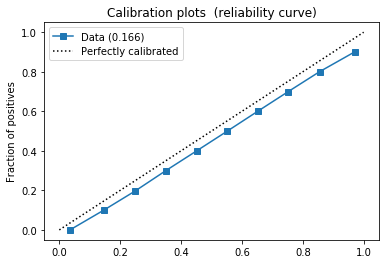

In [27]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

fraction_of_positives, mean_predicted_value = calibration_curve(df_combine['label'], df_combine["prob"], n_bins=10)
clf_score = brier_score_loss(df_combine['label'], df_combine["prob"], pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve)')
plt.legend()
plt.show()